****
**Reference Corpus:**
****

In [1]:
import ijson
import json
import os
from multiprocessing import Pool

def process_ngram_chunk(chunk):
    # Initialize dictionaries for each n-gram size
    chunk_dicts = {n: {} for n in range(2, 6)}
    
    # Process each n-gram in the chunk
    for ngram, count in chunk.items():
        n = len(ngram.split())
        if n in chunk_dicts:
            chunk_dicts[n][ngram] = count
            
    return chunk_dicts

def merge_dicts(dict_list):
    merged = {n: {} for n in range(2, 6)}
    for d in dict_list:
        for n in range(2, 6):
            merged[n].update(d[n])
    return merged

# Create directory if it doesn't exist
os.makedirs('../data/corpus/middle_english_pd_1', exist_ok=True)

# Read the entire file into chunks
chunks = []
chunk_size = 1000  # Adjust this value based on your memory constraints
current_chunk = {}

with open('../data/corpus/middle_english_pd_sentence_ngrams_1.json', 'r', encoding='utf-8') as f:
    parser = ijson.items(f, '')
    for obj in parser:
        current_chunk.update(obj)
        if len(current_chunk) >= chunk_size:
            chunks.append(current_chunk)
            current_chunk = {}
    if current_chunk:  # Add the last chunk if it's not empty
        chunks.append(current_chunk)

# Process chunks in parallel
with Pool() as pool:
    results = pool.map(process_ngram_chunk, chunks)

# Merge results
reference = merge_dicts(results)

# Save each n-gram dictionary to a separate file
for n, ngram_dict in reference.items():
    output_path = f'../data/corpus/middle_english_pd_1/{n}-gram.json'
    with open(output_path, 'w', encoding='utf-8') as f:
        json.dump(ngram_dict, f, ensure_ascii=False, indent=4)

In [4]:
# number of n-grams per n-gram size in the reference corpus
print("The Reference Corpus contains:")
for n, ngram_dict in reference.items():
    print(f"\t{len(ngram_dict)/10**6:.2f} million {n}-grams")

The Reference Corpus contains:
	27.51 million 2-grams
	61.56 million 3-grams
	81.73 million 4-grams
	86.81 million 5-grams


In [6]:
# sort the n-grams by frequency
for n, ngram_dict in reference.items():
    reference[n] = dict(sorted(ngram_dict.items(), key=lambda x: x[1], reverse=True))

In [12]:
# min and max frequency of the top 1000 n-grams for each n-gram size
for n, ngram_dict in reference.items():
    top_1000 = list(ngram_dict.values())[:1000]
    print(f"For {n}-grams:")
    print(f"\tMin frequency: {min(top_1000)}")
    print(f"\tMax frequency: {max(top_1000)}")

For 2-grams:
	Min frequency: 5546
	Max frequency: 836710
For 3-grams:
	Min frequency: 1275
	Max frequency: 17775
For 4-grams:
	Min frequency: 293
	Max frequency: 6529
For 5-grams:
	Min frequency: 84
	Max frequency: 1179


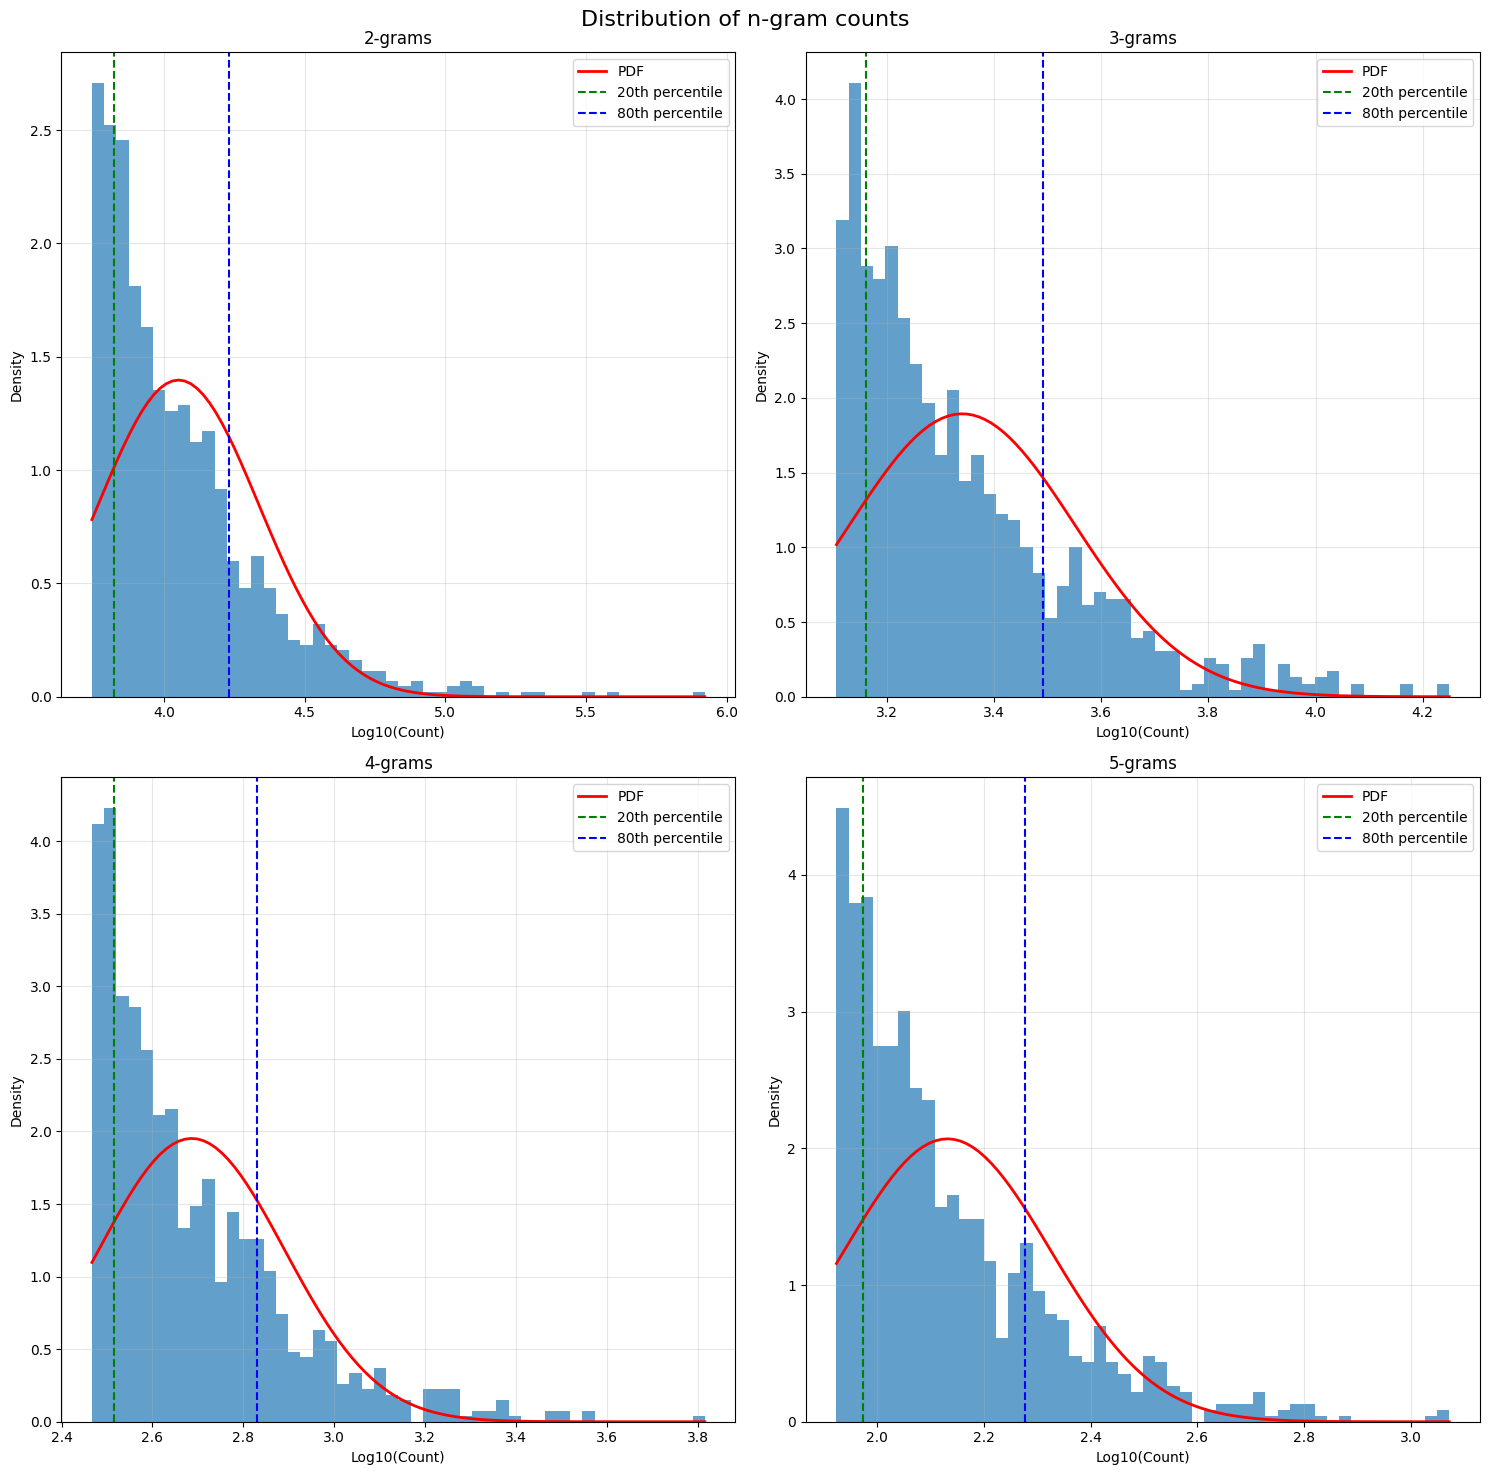

In [14]:
import matplotlib.pyplot as plt
import numpy as np

# 2*2 grid plot showing the distribution of n-grams in based on their counts
def plot_ngram_distribution(ngram_dict, n):
    # Create a figure with 2x2 subplots
    fig, axs = plt.subplots(2, 2, figsize=(15, 15))
    fig.suptitle(f'Distribution of n-gram counts', fontsize=16)

    # Flatten axs for easier iteration
    axs = axs.flatten()

    for i, (n, data) in enumerate(ngram_dict.items()):
        counts = list(data.values())
        
        # Calculate percentiles
        p20 = np.percentile(counts, 20)
        p80 = np.percentile(counts, 80)
        
        # Create histogram with log scale due to large range
        counts_log = np.log10(counts)
        hist, bins, _ = axs[i].hist(counts_log, bins=50, density=True, alpha=0.7)
        
        # Fit normal distribution to log-transformed data
        mu, sigma = np.mean(counts_log), np.std(counts_log)
        x = np.linspace(min(counts_log), max(counts_log), 100)
        pdf = 1/(sigma * np.sqrt(2*np.pi)) * np.exp(-(x-mu)**2/(2*sigma**2))
        
        # Plot PDF
        axs[i].plot(x, pdf, 'r-', lw=2, label='PDF')
        
        # Add vertical lines for percentiles
        axs[i].axvline(np.log10(p20), color='g', linestyle='--', label='20th percentile')
        axs[i].axvline(np.log10(p80), color='b', linestyle='--', label='80th percentile')
        
        # Customize plot
        axs[i].set_title(f'{n}-grams')
        axs[i].set_xlabel('Log10(Count)')
        axs[i].set_ylabel('Density')
        axs[i].legend()
        axs[i].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

# Plot the distribution of n-grams in the reference corpus
reference_plot = {n: dict(list(reference[n].items())[:1000]) for n in reference.keys()}
plot_ngram_distribution(reference_plot, n)

In [4]:
import json
from tqdm import tqdm

# load the n-grams from the reference corpus, sort them by frequency, and save the top 1000 n-grams to a new file
def save_top_ngrams(ngram_dict, n, top_n=1000, file_path='../data/corpus/middle_english_pd_1/2-gram.json'):
    # Sort n-grams by frequency
    sorted_ngrams = dict(sorted(ngram_dict.items(), key=lambda x: x[1], reverse=True))
    
    # Save top n-grams to a new file
    output_path = file_path.replace('.json', f'_top_{top_n}.json')
    with open(output_path, 'w', encoding='utf-8') as f:
        json.dump(dict(list(sorted_ngrams.items())[:top_n]), f, ensure_ascii=False, indent=4)

# Save the top 1000 n-grams for each n-gram size
for index in tqdm(range(2, 6)):
    file_path = f'../data/corpus/middle_english_pd_1/{index}-gram.json'
    # load the n-grams from the reference corpus
    with open(file_path, 'r', encoding='utf-8') as f:
        ngram_dict = json.load(f)
    save_top_ngrams(ngram_dict, index, top_n=1000, file_path=file_path)

  0%|          | 0/4 [00:00<?, ?it/s]

100%|██████████| 4/4 [06:39<00:00, 99.89s/it] 


****
**Target Corpus:**
****

In [16]:
import ijson
import json
import os
from multiprocessing import Pool

# Create directory if it doesn't exist
os.makedirs('../data/corpus/reddit_10', exist_ok=True)

# Read the entire file into chunks
chunks = []
chunk_size = 1000  # Adjust this value based on your memory constraints
current_chunk = {}

# load the target corpora '../data/corpus/reddit_sentence_ngrams_10.json'
with open('../data/corpus/reddit_sentence_ngrams_10.json', 'r', encoding='utf-8') as f:
    parser = ijson.items(f, '')
    for obj in parser:
        current_chunk.update(obj)
        if len(current_chunk) >= chunk_size:
            chunks.append(current_chunk)
            current_chunk = {}
    if current_chunk:  # Add the last chunk if it's not empty
        chunks.append(current_chunk)

# Process chunks in parallel
with Pool() as pool:
    results = pool.map(process_ngram_chunk, chunks)

# Merge results
target = merge_dicts(results)

# Save each n-gram dictionary to a separate file
for n, ngram_dict in target.items():
    output_path = f'../data/corpus/reddit_10/{n}-gram.json'
    with open(output_path, 'w', encoding='utf-8') as f:
        json.dump(ngram_dict, f, ensure_ascii=False, indent=4)


In [21]:
# number of n-grams per n-gram size in the target corpus
print("The Target Corpus contains:")
for n, ngram_dict in target.items():
    print(f"\t{len(ngram_dict)/10**6:.2f} million {n}-grams")

The Target Corpus contains:
	8.96 million 2-grams
	30.03 million 3-grams
	48.57 million 4-grams
	55.63 million 5-grams


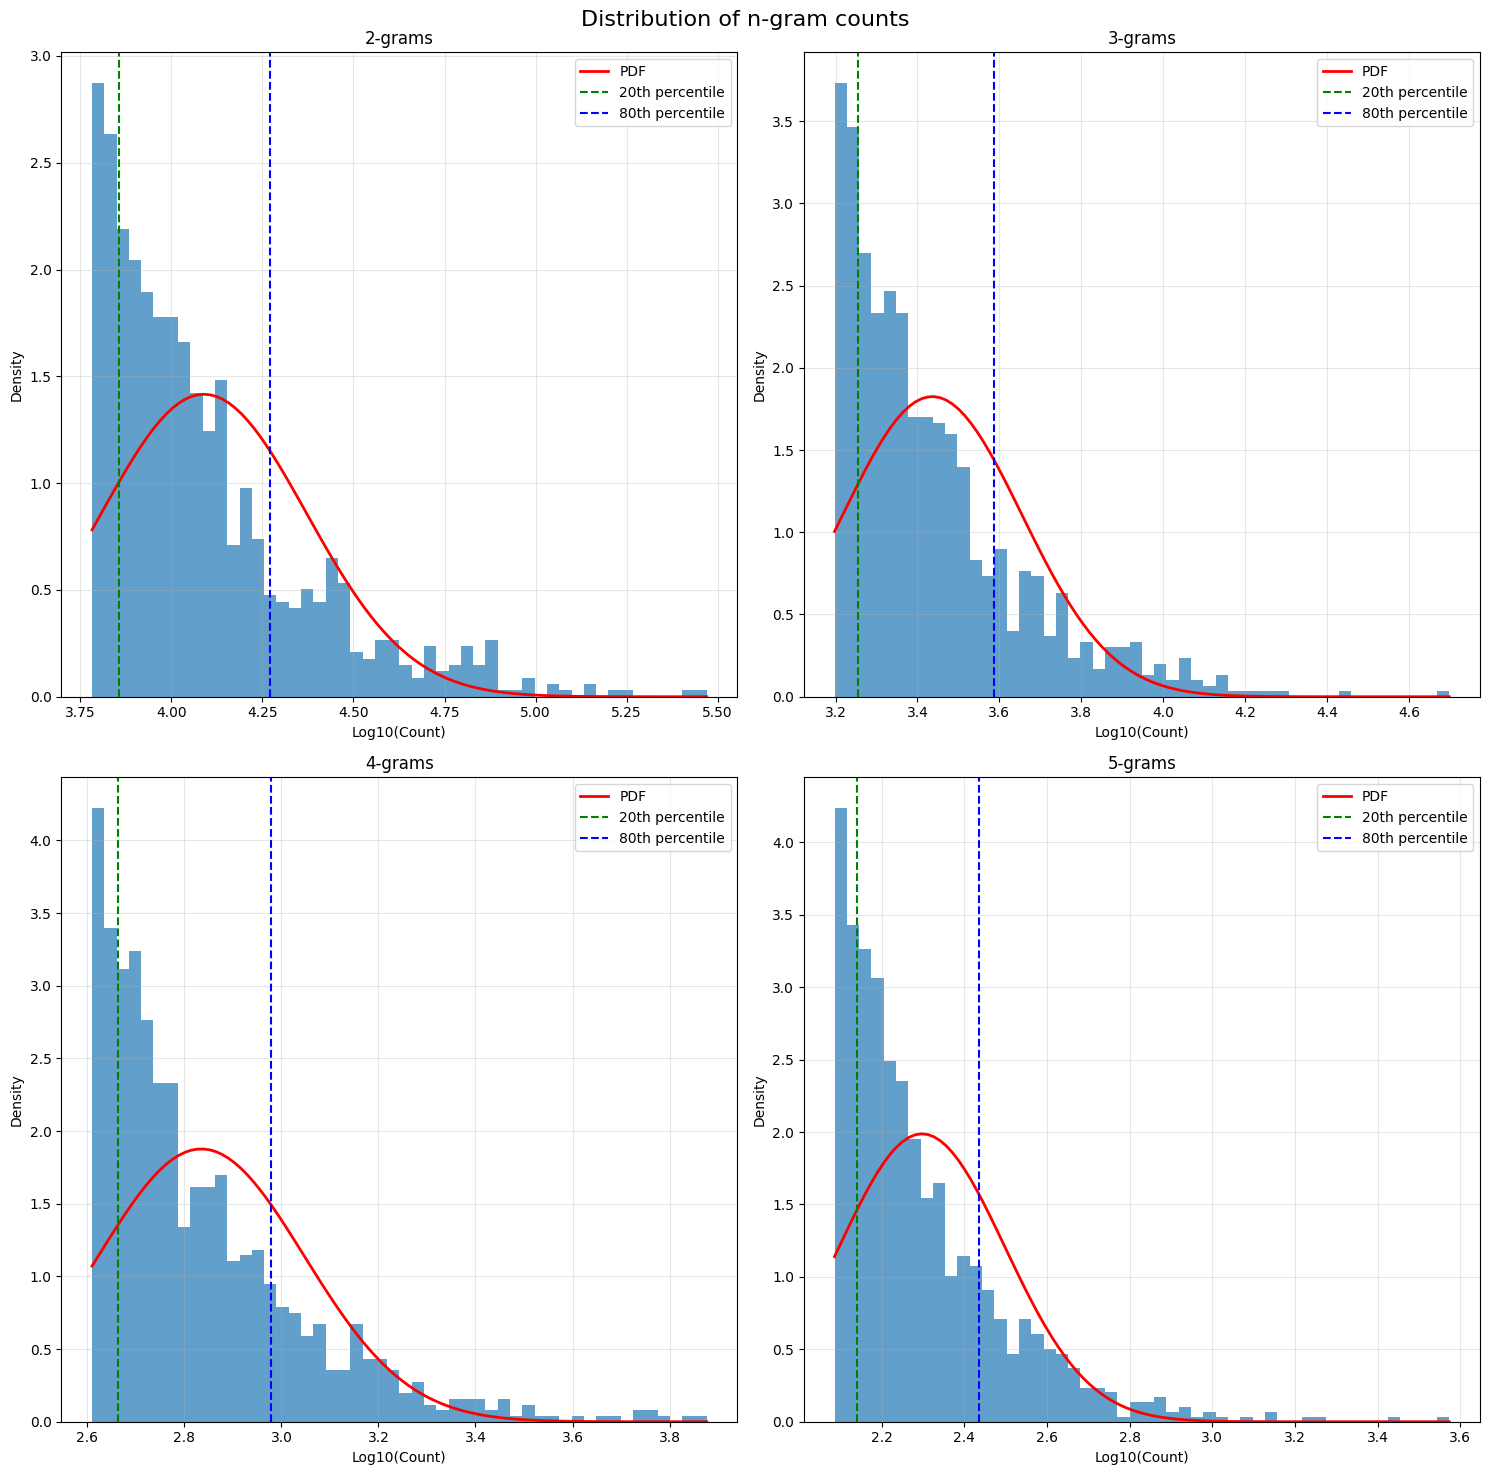

In [22]:
# Plot the distribution of the top 1000 n-grams in the target corpus
plot_ngram_distribution({n: dict(list(target[n].items())[:1000]) for n in target.keys()}, n)

In [18]:
# sort the n-grams by frequency
for n, ngram_dict in target.items():
    target[n] = dict(sorted(ngram_dict.items(), key=lambda x: x[1], reverse=True))

In [19]:
# min and max frequency of the top 1000 n-grams for each n-gram size
for n, ngram_dict in target.items():
    top_1000 = list(ngram_dict.values())[:1000]
    print(f"For {n}-grams:")
    print(f"\tMin frequency: {min(top_1000)}")
    print(f"\tMax frequency: {max(top_1000)}")

For 2-grams:
	Min frequency: 6054
	Max frequency: 295160
For 3-grams:
	Min frequency: 1576
	Max frequency: 49921
For 4-grams:
	Min frequency: 407
	Max frequency: 7528
For 5-grams:
	Min frequency: 122
	Max frequency: 3741


In [5]:
import json
from tqdm import tqdm

# load the n-grams from the reference corpus, sort them by frequency, and save the top 1000 n-grams to a new file
def save_top_ngrams(ngram_dict, n, top_n=1000, file_path='../data/corpus/reddit_10/2-gram.json'):
    # Sort n-grams by frequency
    sorted_ngrams = dict(sorted(ngram_dict.items(), key=lambda x: x[1], reverse=True))
    
    # Save top n-grams to a new file
    output_path = file_path.replace('.json', f'_top_{top_n}.json')
    with open(output_path, 'w', encoding='utf-8') as f:
        json.dump(dict(list(sorted_ngrams.items())[:top_n]), f, ensure_ascii=False, indent=4)

# load the n-grams from the target corpus, sort them by frequency, and save the top 1000 n-grams to a new file
for index in tqdm(range(2, 6)):
    file_path = f'../data/corpus/reddit_10/{index}-gram.json'
    # load the n-grams from the reference corpus
    with open(file_path, 'r', encoding='utf-8') as f:
        ngram_dict = json.load(f)
    save_top_ngrams(ngram_dict, index, top_n=1000, file_path=file_path)

100%|██████████| 4/4 [03:45<00:00, 56.34s/it]


****
**Extracting the Candidate MWEs:**
****

In [1]:
import json
import math

def calculate_pmi(reference_dict, target_dict, total_reference_words, total_target_words, file_path):
    """
    Calculate PMI for target n-grams based on reference n-grams.
    
    Args:
        reference_dict (dict): Reference dictionary with n-grams and their counts.
        target_dict (dict): Target dictionary with n-grams and their counts.
        total_reference_words (int): Total word count in the reference corpus.
        total_target_words (int): Total word count in the target corpus.
        file_path (str): Path to save the results as a JSON file.
    """
    # Initialize small smoothing value for missing data
    epsilon = 1e-10
    
    # Output dictionary to store PMI values
    pmi_results = {}
    
    for ngram, target_count in target_dict.items():
        # Calculate target probability
        p_target = target_count / total_target_words
        
        # Get reference count (0 if not found) and calculate reference probability
        reference_count = reference_dict.get(ngram, 0)
        p_reference = reference_count / total_reference_words if reference_count > 0 else epsilon
        
        # Calculate PMI
        pmi = round(math.log2(p_target / p_reference), 2)
        
        # Store count and PMI in results
        pmi_results[ngram] = {'count': target_count, 'PMI': pmi}
    
    # Save results to file
    if not file_path:
        print(json.dumps(pmi_results, indent=4))
    else:
        with open(file_path, 'w', encoding='utf-8') as f:
            json.dump(pmi_results, f, indent=4)
        print(f"PMI results saved to {file_path}")

# Example inputs
reference_dict = {"hello world": 100, "good morning": 98, "machine learning": 120}
target_dict = {"hello world": 50, "deep learning": 38}
total_reference_words = 123380000  # 123.38 million <- should be dynamically calculated later from the reference corpus
total_target_words = 77620000     # 77.62 million <- should be dynamically calculated later from the target corpus
# file_path = "pmi_results.json"

# Run the function
print("Testing the PMI calculation:")
calculate_pmi(reference_dict, target_dict, total_reference_words, total_target_words, file_path=None)

Testing the PMI calculation:
{
    "hello world": {
        "count": 50,
        "PMI": -0.33
    },
    "deep learning": {
        "count": 38,
        "PMI": 12.26
    }
}


In [2]:
import json
from tqdm import tqdm

# load and calculate the PMI for the top 1000 n-grams in the target corpus vs the reference corpus
for index in tqdm(range(2, 6)):
    # Load n-grams from the target corpus
    target_file_path = f'../data/corpus/reddit_10/{index}-gram_top_1000.json'
    with open(target_file_path, 'r', encoding='utf-8') as f:
        target_dict = json.load(f)
    
    # Load n-grams from the complete reference corpus
    reference_file_path = f'../data/corpus/middle_english_pd_1/{index}-gram.json'
    with open(reference_file_path, 'r', encoding='utf-8') as f:
        reference_dict = json.load(f)
    
    # Calculate PMI
    calculate_pmi(reference_dict, target_dict, total_reference_words, total_target_words, file_path=f'../data/corpus/reddit_10/{index}-gram_top_1000_pmi.json')

print("All PMI calculations completed!")

 25%|██▌       | 1/4 [00:24<01:12, 24.26s/it]

PMI results saved to ../data/corpus/reddit_10/2-gram_top_1000_pmi.json


 50%|█████     | 2/4 [01:20<01:26, 43.29s/it]

PMI results saved to ../data/corpus/reddit_10/3-gram_top_1000_pmi.json


 75%|███████▌  | 3/4 [02:37<00:58, 58.52s/it]

PMI results saved to ../data/corpus/reddit_10/4-gram_top_1000_pmi.json


100%|██████████| 4/4 [04:00<00:00, 60.17s/it]

PMI results saved to ../data/corpus/reddit_10/5-gram_top_1000_pmi.json
All PMI calculations completed!


In [32]:
import math
import plotly.graph_objects as go
from plotly.subplots import make_subplots

def plot_pmi_and_counts_2x2(dicts, total_plot_size=(800, 1200), top_n=1000):
    """
    Plots PMI and normalized counts for n-grams (n=2 to 5) in a 2x2 grid.
    
    Args:
        dicts (list): List of 4 dictionaries for n-grams with count and PMI values.
                      Format: {ngram: {'count': count, 'PMI': pmi}}
        total_plot_size (tuple): Tuple specifying (width, height) of the total plot.
        top_n (int): Number of top n-grams to include in each subplot.
    """
    # Create subplot structure (2 rows x 2 columns)
    fig = make_subplots(
        rows=2, cols=2,
        subplot_titles=["2-grams", "3-grams", "4-grams", "5-grams"],
        horizontal_spacing=0.1, vertical_spacing=0.15
    )
    
    # Colors for PMI and normalized counts
    pmi_color = "rgb(31, 119, 180)"
    count_color = "rgb(255, 127, 14)"
    
    for i, pmi_dict in enumerate(dicts):
        # Determine subplot row and column
        row = (i // 2) + 1
        col = (i % 2) + 1
        
        # Extract data and sort by PMI
        sorted_ngrams = sorted(pmi_dict.items(), key=lambda x: x[1]['PMI'], reverse=True)[:top_n]
        ngrams = [item[0] for item in sorted_ngrams]
        counts = [item[1]['count'] for item in sorted_ngrams]
        pmi_values = [item[1]['PMI'] for item in sorted_ngrams]

        # Normalize counts to log scale
        normalized_counts = [math.log10(c + 1) for c in counts]  # Add 1 to avoid log(0)

        # Create bar plots for PMI and Counts
        pmi_bars = go.Bar(
            x=ngrams,
            y=pmi_values,
            name="PMI",
            marker=dict(color=pmi_color),
            hovertemplate="<b>{n}-gram</b>: %{x}<br>PMI: %{y:.4f}<extra></extra>",
            showlegend=(i == 0),  # Show legend only in the first subplot
            opacity=1,  # Fully opaque
        )
        
        count_bars = go.Bar(
            x=ngrams,
            y=normalized_counts,
            name="Log Count",
            marker=dict(color=count_color),
            hovertemplate="<b>{n}-gram</b>: %{x}<br>Count (log): %{y:.4f}<extra></extra>",
            showlegend=(i == 0),  # Show legend only in the first subplot
            opacity=1,  # Fully opaque
        )
        
        # Add traces to the appropriate subplot
        fig.add_trace(pmi_bars, row=row, col=col)
        fig.add_trace(count_bars, row=row, col=col)
    
    # Update layout
    fig.update_layout(
        height=total_plot_size[1],
        width=total_plot_size[0],
        title="PMI vs Normalized Counts for N-grams (2-grams to 5-grams)",
        barmode="group",  # Group the bars side-by-side
        hovermode="x unified",
        legend=dict(title="Legend"),
    )

    # set the width of the bar line to zero, and set bargap to zero
    fig.update_traces(marker_line_width=0)
    fig.update_layout(bargap=0)
    
    # Update axes for all subplots
    fig.update_xaxes(title="N-grams", tickangle=45, showticklabels=False)
    fig.update_yaxes(title="Normalized Values")
    
    # Show the plot
    fig.show()

# load the PMI results for the top 1000 n-grams in the target corpus vs the reference corpus
pmi_results = []
for index in range(2, 6):
    # Load PMI results
    file_path = f'../data/corpus/reddit_10/{index}-gram_top_1000_pmi.json'
    with open(file_path, 'r', encoding='utf-8') as f:
        pmi_dict = json.load(f)
    pmi_results.append(pmi_dict)

# Plot PMI and normalized counts for n-grams (2-grams to 5-grams) in a 2x2 grid
plot_pmi_and_counts_2x2(pmi_results, total_plot_size=(1200, 800), top_n=1000)